In [ ]:
import tkinter as tk
from tkinter import messagebox, Toplevel
from tkinter import ttk                # ensure ttk is imported
import calendar
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import pyodbc
import numpy as np
import pandas as pd

Loading time for: 9E 
❌ Error fetching CRSDepTimes: not enough values to unpack (expected 2, got 1)
Found times for 9E : []
Loading time for: DL 1191
Found times for DL 1191: ['05:15:00', '05:45:00', '05:50:00', '07:10:00', '08:27:00', '08:38:00', '08:42:00', '08:50:00', '08:55:00', '11:15:00', '11:29:00', '11:30:00', '11:36:00', '16:55:00', '17:57:00', '18:35:00', '18:50:00', '21:08:00', '21:10:00', '21:38:00']
❌ Error fetching cities: ('42S22', "[42S22] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Invalid column name 'OriginCityName'. (207) (SQLExecDirectW)")


/opt/miniconda3/lib/python3.12/tkinter/__init__.py:861: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args)


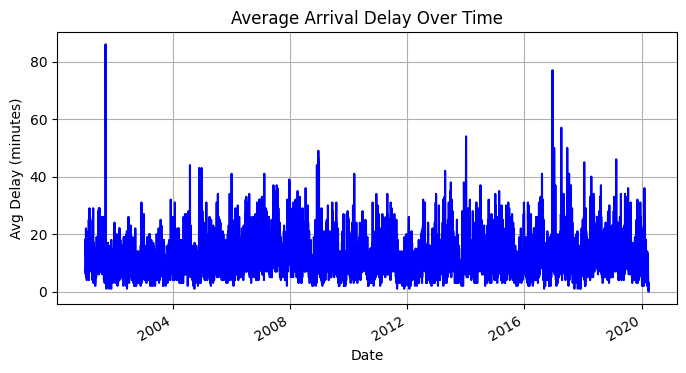

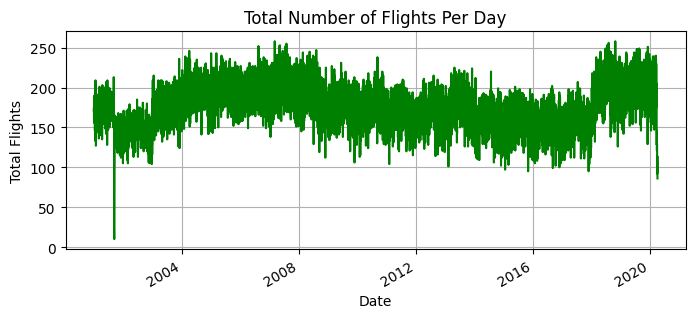

/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


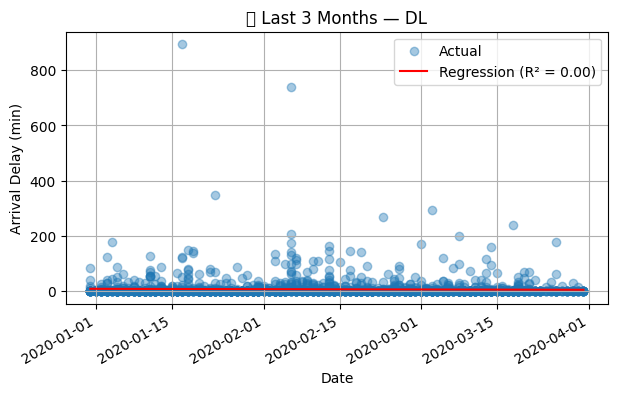

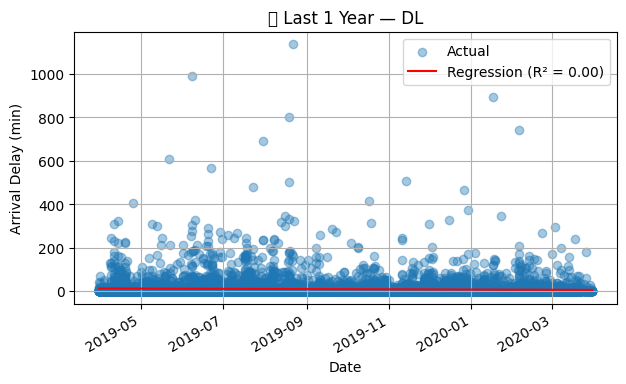

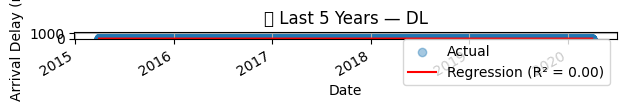

In [2]:


def show_regression_for_airline(airline_code):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    win = Toplevel()
    win.title(f"Delay Regression: {airline_code}")
    win.geometry("1200x900")
    win.configure(bg='white')

    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()
        query = """
        SELECT FlightDate, ArrDelayMinutes
        FROM ops.Flights f
        LEFT JOIN meta.ReportingAirline ra ON f.ReportingAirlineID = ra.ReportingAirlineID
        WHERE ra.ReportingAirline = ?
          AND ArrDelayMinutes IS NOT NULL
        ORDER BY FlightDate
        """
        cursor.execute(query, (airline_code,))
        rows = cursor.fetchall()
        conn.close()

        if not rows:
            tk.Label(win, text="No data found.", bg='white', fg='red').pack()
            return

        df = pd.DataFrame([(row.FlightDate, row.ArrDelayMinutes) for row in rows], columns=["FlightDate", "ArrDelayMinutes"])
        df["FlightDate"] = pd.to_datetime(df["FlightDate"])
        df = df.dropna()

        now = pd.to_datetime("2020-03-31")  # Assuming max date from your database

        def plot_subset(title, subset_df):
            if len(subset_df) < 2:
                print(f"Not enough data for {title}")
                return

            X = subset_df["FlightDate"].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
            y = subset_df["ArrDelayMinutes"].values
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)

            fig, ax = plt.subplots(figsize=(7, 4))
            ax.scatter(subset_df["FlightDate"], y, alpha=0.4, label='Actual')
            ax.plot(subset_df["FlightDate"], y_pred, color='red', label=f'Regression (R² = {r2:.2f})')
            ax.set_title(f"{title} — {airline_code}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Arrival Delay (min)")
            ax.legend()
            ax.grid(True)
            fig.autofmt_xdate()
            FigureCanvasTkAgg(fig, master=win).get_tk_widget().pack(pady=5)

        # Subsets
        plot_subset("📉 Last 3 Months", df[df["FlightDate"] >= now - pd.DateOffset(months=3)])
        plot_subset("📉 Last 1 Year", df[df["FlightDate"] >= now - pd.DateOffset(years=1)])
        plot_subset("📉 Last 5 Years", df[df["FlightDate"] >= now - pd.DateOffset(years=5)])

    except Exception as e:
        print("❌ Error in regression:", e)
        tk.Label(win, text="Error loading data", bg='white', fg='red').pack()


def query_avg_arrival_delay_by_date():
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()
        cursor.execute("""
            SELECT FlightDate, AVG(ArrDelayMinutes) AS AvgArrivalDelay
            FROM ops.Flights
            GROUP BY FlightDate
            ORDER BY FlightDate;
        """)
        rows = cursor.fetchall()
        conn.close()
        return [row.FlightDate for row in rows], [row.AvgArrivalDelay for row in rows]
    except Exception as e:
        print("❌ Error querying avg arrival delay:", e)
        return [], []

def query_total_flights_by_date():
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()
        cursor.execute("""
            SELECT FlightDate, COUNT(*) AS TotalFlights
            FROM ops.Flights
            GROUP BY FlightDate
            ORDER BY FlightDate;
        """)
        rows = cursor.fetchall()
        conn.close()
        return [row.FlightDate for row in rows], [row.TotalFlights for row in rows]
    except Exception as e:
        print("❌ Error querying total flights:", e)
        return [], []

def show_plots_in_compare_window(parent_window):
    plot_win = Toplevel(parent_window)
    plot_win.title("Flight Delay Visualizations")
    plot_win.geometry("1000x800")
    plot_win.configure(bg='white')

    dates1, avg_delays = query_avg_arrival_delay_by_date()
    dates2, total_flights = query_total_flights_by_date()

    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(dates1, avg_delays, color="blue")
    ax1.set_title("Average Arrival Delay Over Time")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Avg Delay (minutes)")
    ax1.grid(True)
    fig1.autofmt_xdate()
    FigureCanvasTkAgg(fig1, master=plot_win).get_tk_widget().pack(pady=20)

    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(dates2, total_flights, color="green")
    ax2.set_title("Total Number of Flights Per Day")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Total Flights")
    ax2.grid(True)
    fig2.autofmt_xdate()
    FigureCanvasTkAgg(fig2, master=plot_win).get_tk_widget().pack(pady=20)

#Queries to find distnict airlines
def get_distinct_airlines():
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()
        cursor.execute("SELECT DISTINCT ReportingAirline FROM meta.ReportingAirline")
        result = [row[0] for row in cursor.fetchall()]
        conn.close()
        return result
    except Exception as e:
        print("❌ Error fetching airlines:", e)
        return []

#Queries to find distnict city
def get_distinct_cities():
    try:
        conn = pyodbc.connect( 
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;" )  # same as above
        cursor = conn.cursor()
        cursor.execute("SELECT DISTINCT OriginCityName FROM ops.Origin")
        result = [row[0] for row in cursor.fetchall()]
        conn.close()
        return result
    except Exception as e:
        print("❌ Error fetching cities:", e)
        return []

#Queries to find distnict date
def get_distinct_dates():
    try:
        conn = pyodbc.connect( 
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;" )  # same as above
        cursor = conn.cursor()
        query = """
        SELECT DISTINCT FlightDate 
        FROM ops.Flights 
        ORDER BY FlightDate DESC"""
        cursor.execute("SELECT DISTINCT FlightDate FROM ops.Flights ORDER BY FlightDate DESC")
        result = [row[0] for row in cursor.fetchall()]
        conn.close()
        return result
    except Exception as e:
        print("❌ Error fetching dates:", e)
        return []

#calculating avg delay
def calculate_avg_delay(airline=None, city=None, date=None):
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()

        query = """
        SELECT 
            AVG(f.DepDelayMinutes) AS AvgDelay,
            COUNT(*) AS TotalFlights,
            COUNT(DISTINCT f.OriginAirportSeqID) AS AirportTraffic
        FROM ops.Flights f
        LEFT JOIN ops.Origin o ON f.OriginAirportSeqID = o.OriginAirportSeqID
        LEFT JOIN meta.ReportingAirline ra ON f.ReportingAirlineID = ra.ReportingAirlineID
        WHERE 1=1
        """
        params = []

        if airline:
            query += " AND ra.ReportingAirline = ?"
            params.append(airline)
        if city:
            query += " AND o.OriginCityName = ?"
            params.append(city)
        if date:
            query += " AND f.FlightDate = ?"
            params.append(date)

        cursor.execute(query, tuple(params))
        row = cursor.fetchone()
        conn.close()

        if row:
            return {
                "AvgDelay": row.AvgDelay,
                "TotalFlights": row.TotalFlights,
                "AirportTraffic": row.AirportTraffic
            }
        else:
            return None
    except Exception as e:
        print("❌ Error calculating avg delay:", e)
        return None


#Matching the departure time with the flight number
def get_matching_departure_times(full_flight_number):
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )
        cursor = conn.cursor()

        # Split airline code and flight number
        code, number = full_flight_number.split()

        query = """
        SELECT DISTINCT f.CRSDepTime
        FROM ops.Flights f
        LEFT JOIN meta.ReportingAirline ra ON f.ReportingAirlineID = ra.ReportingAirlineID
        WHERE f.FlightNumberReportingAirline = ?
          AND ra.ReportingAirline = ?
        ORDER BY f.CRSDepTime;
        """
        cursor.execute(query, (number, code))
        times = [str(row.CRSDepTime) for row in cursor.fetchall()]  # Ensure string format
        conn.close()
        return times
    except Exception as e:
        print("❌ Error fetching CRSDepTimes:", e)
        return []

# Searching Flight Info
def search_flight_info(full_flight_number, crs_time_str):
    """
    Queries SQL Server for a flight using the format 'DL 1191' and CRSDepTime = 'HH:MM:SS'
    Returns flight details (origin, destination, arrival, status) as a dictionary
    """
    print(f"🔍 Searching for {full_flight_number} @ {crs_time_str}")
    try:
        conn = pyodbc.connect(
            "DRIVER={ODBC Driver 18 for SQL Server};"
            "SERVER=127.0.0.1,1433;"
            "DATABASE=Airline_Reporting_Carrier;"
            "UID=sa;"
            "PWD=Hunter3322!;"
            "Encrypt=no;"
            "TrustServerCertificate=yes;"
        )

        cursor = conn.cursor()

        # Split the airline and number
        code, number = full_flight_number.split()

        query = """
        SELECT 
            ra.ReportingAirline + ' ' + CAST(f.FlightNumberReportingAirline AS VARCHAR) AS FullFlightNumber,
            f.FlightDate,
            o.OriginStateName AS Origin,
            d.DestStateName AS Destination,
            f.ArrTime AS ScheduledArrival,
            CASE 
                WHEN f.DepDelayMinutes IS NULL OR f.DepDelayMinutes <= 15 THEN 'On-time'
                ELSE 'Delayed'
            END AS Status
        FROM ops.Flights f
        LEFT JOIN ops.Origin o ON f.OriginAirportSeqID = o.OriginAirportSeqID
        LEFT JOIN ops.Destination d ON f.DestAirportSeqID = d.DestAirportSeqID
        LEFT JOIN meta.ReportingAirline ra ON f.ReportingAirlineID = ra.ReportingAirlineID
        WHERE 
            ra.ReportingAirline = ?
            AND f.FlightNumberReportingAirline = ?
            AND CONVERT(VARCHAR(8), f.CRSDepTime, 108) = ?
        """

        cursor.execute(query, (code, number, crs_time_str))
        result = cursor.fetchone()
        conn.close()

        if result:
            print("✅ Query succeeded. Data:", result)
            return {
                "FlightNumber": result.FullFlightNumber,
                "FlightDate": result.FlightDate,
                "Origin": result.Origin,
                "Destination": result.Destination,
                "ScheduledArrival": result.ScheduledArrival,
                "Status": result.Status
            }
        else:
            print("Query executed, but no matching row found.")
            return None

    except Exception as e:
        print("❌ SQL query failed:", e)
        return None

# 1) Main Search Window
def main():
    search_win = tk.Tk()
    search_win.title("Flight Lookup")
    search_win.geometry("750x500")
    search_win.configure(bg='#ffcccc')

    tk.Label(search_win, text="Select Airline:",fg = 'black', bg='#ffcccc').pack(pady=5)

    #NEW: Define airline code → full name dictionary
    airlines = {
    "9E": "Endeavor Air",
    "AA": "American Airlines",
    "AQ": "Aloha Airlines",
    "AS": "Alaska Airlines",
    "B6": "JetBlue Airways",
    "CO": "Continental Airlines",
    "DH": "Independence Air",
    "DL": "Delta Air Lines",
    "EV": "ExpressJet Airlines",
    "F9": "Frontier Airlines",
    "FL": "AirTran Airways",
    "G4": "Allegiant Air",
    "HA": "Hawaiian Airlines",
    "HP": "America West Airlines",
    "MQ": "Envoy Air (formerly American Eagle)",
    "NK": "Spirit Airlines",
    "NW": "Northwest Airlines",
    "OH": "Comair",
    "OO": "SkyWest Airlines",
    "RU": "AirBridgeCargo Airlines",
    "TW": "Trans World Airlines (TWA)",
    "TZ": "ATA Airlines",
    "UA": "United Airlines",
    "US": "US Airways",
    "VX": "Virgin America",
    "WN": "Southwest Airlines",
    "XE": "ExpressJet Airlines",
    "YV": "Mesa Airlines",
    "YX": "Midwest Airlines"
    }

    #NEW: Create dropdown list with "DL (Delta Air Lines)" format
    dropdown_display = [f"{code} ({name})" for code, name in airlines.items()]
    
    #NEW: Airline selection Combobox using formatted list
    airline_display_var = tk.StringVar(value=dropdown_display[0])
    airline_dropdown = ttk.Combobox(search_win, textvariable=airline_display_var,
                                    values=dropdown_display, state="readonly")
    airline_dropdown.pack(pady=5)

    tk.Label(search_win, text="Enter Flight Number:",fg = 'black', bg='#ffcccc').pack(pady=5)
    flight_entry = tk.Entry(search_win, font=("Helvetica", 14))
    flight_entry.pack(pady=5)

    # Time selection dropdown and search button (initially hidden)
    time_var = tk.StringVar()
    time_combo = ttk.Combobox(search_win, textvariable=time_var, state="readonly")
    time_combo.pack_forget()

    search_button = tk.Button(search_win, text="Search", command=lambda: do_search())
    search_button.pack_forget()

    #NEW: Extract just the airline code (e.g., "DL") from the selected Combobox string
    def get_airline_code(display_string):
        return display_string.split(" ")[0]
    
    # Button to load departure times
    def load_times():
        code = airline_display_var.get().split()[0]
        number = flight_entry.get().strip()
        full_flight_number = f"{code} {number}"

        print(f"Loading time for: {full_flight_number}")

        times = get_matching_departure_times(full_flight_number)
        print(f"Found times for {full_flight_number}:", times)

        if times:
            time_combo['values'] = times
            time_combo.current(0)
            time_combo.pack(pady=5)

            # Show Search button once time is selected
            def on_time_selected(event=None):
                if time_var.get() and "No matches" not in time_var.get():
                    search_button.config(state='normal')
                    search_button.pack(pady=5)

            time_combo.bind("<<ComboboxSelected>>", on_time_selected)
        else:
            time_combo['values'] = ["No matches"]
            time_combo.current(0)
            time_combo.pack(pady=5)
            search_button.pack_forget()
    
    tk.Button(search_win, text="Load Times", command=load_times).pack(pady=5)

    def do_search():
        code = get_airline_code(airline_display_var.get())
        number = flight_entry.get().strip()
        crs_time = time_var.get()

        if not number or not crs_time or "No matches" in crs_time:
            messagebox.showerror("Input Error", "Please enter valid flight details and select a time.")
            return

        full_flight_number = f"{code} {number}"
        data = search_flight_info(full_flight_number, crs_time)

        if data:
            open_info_window(data)  # ✅ This function opens the info window using result
        else:
            messagebox.showerror("Not Found", f"No flight found for {full_flight_number} at {crs_time}.")
    

    #UPDATED: Pass extracted airline code + flight number to open_info_window
    #tk.Button(search_win, text="Search",
    #          command=lambda: open_info_window(get_airline_code(airline_display_var.get()), flight_entry.get())
    #         ).pack(pady=5)
    
    

    tk.Button(search_win, text="Compare Flights",
              command=open_compare_window
             ).pack(pady=5)

    tk.Button(search_win, text="Forecast Delays",
              command=open_forecast_window
             ).pack(pady=5)

    search_win.mainloop()

# 2) Flight Info Window
def open_info_window(data):
    if not data:
        messagebox.showerror("Error", "No flight data to show.")
        return

    info_win = Toplevel()
    info_win.title(f"Flight Info — {data['FlightNumber']}")
    info_win.geometry("500x300")
    info_win.configure(bg='#ffcccc')

    content = tk.Frame(info_win, bg='#ffcccc')
    content.pack(padx=20, pady=20)

    labels = [
        ("Flight Number", "✈️", data['FlightNumber']),
        ("Date of Takeoff", "📅", data['FlightDate'].strftime('%Y-%m-%d')),
        ("Origin", "📍", data['Origin']),
        ("Destination", "📍", data['Destination']),
        ("Scheduled Arrival", "⏰", data['ScheduledArrival'].strftime('%H:%M')),
        ("Status", "⚠️", data['Status'])
    ]
   

    for i, (field, emoji, value) in enumerate(labels):
        print("Rendering:", field, value)
        # Emoji (col 0)
        tk.Label(content, text=emoji, bg='#ffcccc', font=("Courier", 14)).grid(
            row=i, column=0, sticky='w', padx=5, pady=4)

        # Field label (col 1) — this is what was missing visually before
        tk.Label(content, text=f"{field}:", bg='#ffcccc',fg = 'black', font=("Courier", 12, "bold")).grid(
            row=i, column=1, sticky='w', padx=5)

        # Value (col 2)
        fg_color = (
            "green" if field == "Status" and value == "On-time"
            else "red" if field == "Status"
            else "black")

        tk.Label(content, text=value, bg='#ffcccc', font=("Courier", 12), fg=fg_color).grid(
            row=i, column=2, sticky='w', padx=5)

# 3) Comparison Window
def open_compare_window():
    cmp_win = Toplevel()
    cmp_win.title("Compare with Other Flights")
    cmp_win.geometry("600x400")
    cmp_win.configure(bg='#ffcccc')

    # --- Dropdowns ---
    tk.Label(cmp_win, text="Select Airline:",fg = 'black', bg='#ffcccc').pack()
    airline_var = tk.StringVar()
    airline_combo = ttk.Combobox(cmp_win, textvariable=airline_var, state="readonly")
    airline_combo.pack(pady=5)

    tk.Label(cmp_win, text="Select City:",fg = 'black', bg='#ffcccc').pack()
    city_var = tk.StringVar()
    city_combo = ttk.Combobox(cmp_win, textvariable=city_var, state="readonly")
    city_combo.pack(pady=5)

    tk.Label(cmp_win, text="Select Date:",fg = 'black', bg='#ffcccc').pack()
    date_var = tk.StringVar()
    date_combo = ttk.Combobox(cmp_win, textvariable=date_var, state="readonly")
    date_combo.pack(pady=5)

    # Populate dropdowns
    airline_combo['values'] = get_distinct_airlines()
    city_combo['values'] = get_distinct_cities()
    date_combo['values'] = get_distinct_dates()

    # --- Results display ---
    results_label = tk.Label(cmp_win, text="", fg='black', bg='#ffcccc', font=("Helvetica", 12), justify="left")
    results_label.pack(pady=10)

    tk.Button(cmp_win, text="Show Visualizations", command=lambda: show_plots_in_compare_window(cmp_win)).pack(pady=10)

    tk.Button(cmp_win, text="Show Airline Regression",
          command=lambda: show_regression_for_airline(airline_var.get())).pack(pady=10)

    # --- Query button ---
    def run_comparison():
        airline = airline_var.get()
        city = city_var.get()
        date = date_var.get()

        result = calculate_avg_delay(airline=airline, city=city, date=date)

        if result:
            avg_delay = f"{result['AvgDelay']:.2f} mins" if result['AvgDelay'] else "N/A"
            results = (
                f"✈️ Average Delay: {avg_delay}\n"
                f"🛫 Total Flights: {result['TotalFlights']}\n"
                f"🏙️ Airport Traffic Count: {result['AirportTraffic']}"
            )
            results_label.config(text=results)
        else:
            results_label.config(text="No matching data found or an error occurred.")

    tk.Button(cmp_win, text="Run Comparison", command=run_comparison).pack(pady=10)

# 4) Forecast Window with dynamic month list
API_BASE = "http://localhost:5000/api"   # adjust as needed

def fetch_available_months():
    """
    Stub: GET /api/months
    Returns JSON array of strings, e.g. ["Jan 2025","Feb 2025",...]
    """
    resp = requests.get(f"{API_BASE}/months")
    resp.raise_for_status()
    return resp.json()

def fetch_delay_data(year_month_str):
    """
    Stub: GET /api/delays?month=Jan%202025
    Returns JSON of { days: [...], delays: [...] }
    """
    resp = requests.get(f"{API_BASE}/delays", params={"month": year_month_str})
    resp.raise_for_status()
    return resp.json()

def open_forecast_window():
    fc_win = Toplevel()
    fc_win.title("Arrival-Delay Forecast")
    fc_win.geometry("700x500")
    fc_win.configure(bg='white')

    # 1) Fetch the months list dynamically
    try:
        months = fetch_available_months()  
    except Exception as e:
        messagebox.showerror("Data Error", f"Could not load months:\n{e}")
        fc_win.destroy()
        return

    month_var = tk.StringVar(value=months[0])
    selector = ttk.Combobox(
        fc_win, textvariable=month_var, values=months, state="readonly"
    )
    selector.pack(pady=10)

    # 2) Matplotlib setup
    fig, ax = plt.subplots(figsize=(6, 4))
    canvas = FigureCanvasTkAgg(fig, master=fc_win)
    canvas.get_tk_widget().pack(fill='both', expand=True)

    # 3) Plot callback that asks the back end for data
    def plot_selected_month(event=None):
        sel = month_var.get()
        try:
            data = fetch_delay_data(sel)
        except Exception as e:
            messagebox.showerror("Data Error", f"Could not load data for {sel}:\n{e}")
            return

        days, delays = data["days"], data["delays"]
        ax.clear()
        ax.plot(days, delays, marker='o')
        ax.set_title(f"Arrival Delays — {sel}")
        ax.set_xlabel("Day of Month")
        ax.set_ylabel("Delay (min)")
        ax.grid(True)
        canvas.draw()

    plot_selected_month()
    selector.bind("<<ComboboxSelected>>", plot_selected_month)


if __name__ == "__main__":
    main()